In [1]:
%matplotlib inline

In [1]:
basedir='/home/rms101/SCRIPTS/amoc_stab/'
import sys
sys.path.append(basedir + 'MODS')
import os
import glob
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots as rpl
import rms_utils as rut
import nc as nc
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
################settings
#mpl.style.reload_library()
#plt.style.use('rms_paper')


registering cmaps
registering cmaps


1a. Calculate GM annual mean TAS timeseries LE
#####################################################

In [2]:
rundir='/home/rms101/SCRIPTS/amoc_stab/FIG5_ZECMIP/';os.chdir(rundir)
srcdir_base='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/ESGF/CMIP6/'        
datadir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/DATA/amoc_stab_post'        
    
do_calc=False
varnm='tas'
if do_calc:
    os.system('mkdir -p {}/DATA_{}_ZECMIP'.format(datadir,varnm))
    os.chdir('{}/DATA_{}_ZECMIP'.format(datadir,varnm))
    os.system('/bin/rm *.nc')
    # All 1pctCO2 
    os.system('ln -s ' + srcdir_base +'/CMIP/*/*/1pctCO2/*/Amon/tas/*/*/*.nc .')
    # All esm-1pctCO2 
    os.system('ln -s ' + srcdir_base +'/C4MIP/*/*/esm-1pctCO2/*/Amon/tas/*/*/*.nc .')
    # All 1000PgC 
    os.system('ln -s ' + srcdir_base +'/C4MIP/*/*/esm-1pct-brch-1000PgC/*/Amon/tas/*/*/*.nc .')
    # Remove UKESM1-0-LL (no msftmz data), CanESM5  
    os.system('/bin/rm *UKESM1-0-LL*.nc *CanESM5*.nc')
    # concat
    ens_1pct = rut.cd_mkensemble('*CO2*',mip='cmip6')
    ens_1pct = cd.cat_exp_slices(ens_1pct)

    ens_20c = rut.cd_mkensemble('*esm-1pct-brch-1000PgC*',mip='cmip6')
    ens_20c = cd.cat_exp_slices(ens_20c)

    print 'Calculate global annual mean'
    # annual means            
    my_cdo_str='cdo -yearmean  {infile} {outfile}' 
    ens_1pct=cd.my_operator(ens_1pct, my_cdo_str, output_prefix='am_',delete=True)
    ens_20c=cd.my_operator(ens_20c, my_cdo_str, output_prefix='am_',delete=True)
    # global mean            
    my_cdo_str='cdo -fldmean  {infile} {outfile}' 
    ens_1pct=cd.my_operator(ens_1pct, my_cdo_str, output_prefix='gm',delete=True) 
    ens_20c=cd.my_operator(ens_20c, my_cdo_str, output_prefix='gm',delete=True) 
else:
    os.chdir('{}/DATA_{}_ZECMIP'.format(datadir,varnm))  
    #ens_1pct=rut.cd_mkensemble('gmam_*CO2*',prefix='gmam_',mip='cmip6')    
    #ens_20c=rut.cd_mkensemble('gmam_*_esm-1pct-brch-1000PgC*',prefix='gmam_',mip='cmip6')    

##Read 1pct
ntmax=150
files_1pct=sorted(glob.glob('*1pctCO2*')); nmod=len(files_1pct)
tas_1pct=np.zeros((nmod,ntmax))*np.nan
modnames= []
for i in range(nmod):
    modnames.append(files_1pct[i].split('_')[3])
    tas_tmp=nc.getvar(files_1pct[i],'tas').squeeze()
    nt=len(tas_tmp)
    tas_1pct[i,0:nt]=tas_tmp
print modnames

##Read 20c
ntmax=300
files_20c=sorted(glob.glob('*1000PgC*')); nmod=len(files_20c)
tas_20c=np.zeros((nmod,ntmax))*np.nan
modnames= []
for i in range(nmod):
    tas_tmp=nc.getvar(files_20c[i],'tas').squeeze()
    nt=len(tas_tmp)
    tas_20c[i,0:nt]=tas_tmp
    modnames.append(files_20c[i].split('_')[3])
print modnames
os.chdir(rundir)


['ACCESS-ESM1-5', 'CESM2', 'GISS-E2-1-G-CC', 'NorESM2-LM']
['ACCESS-ESM1-5', 'CESM2', 'GISS-E2-1-G-CC', 'NorESM2-LM']


2. Plot
#####################################################

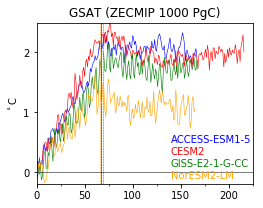

In [4]:
fig1, ax = plt.subplots(1,1, figsize=(8,8)); 
fig1.subplots_adjust(bottom=0.6,right=0.5,hspace=0.3,wspace=0.25)

####### years    
years=np.arange(1,ntmax+1)

# Axis
ax.set_xlim([0, 225]) 
ax.set_xticks(np.arange(0,250,25))
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25)) 

ax.set_ylim([-0.2, 2.5])
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('$^\circ$C')
    
####### plot
colors=['blue','red','green','orange']

ntbreak=[66,66,68,65] #endpoint of 1pct in year-1 units
linestyle=['solid','dashed','dashed','dashed'] 
for i in range(nmod):
    
    years=range(ntbreak[i]+1)
    tas=tas_1pct[i,0:ntbreak[i]+1]-tas_1pct[i,0]
    ax.plot(years,tas,colors[i],linewidth=0.6,label=modnames[i])

    years=np.arange((ntbreak[i]+1),(ntbreak[i]+301))
    tas=tas_20c[i,:]-tas_1pct[i,0]
    ax.plot(years,tas,colors[i],linewidth=0.6,label=modnames[i])

    ax.text(140,0.5-i*0.2,modnames[i],color= colors[i])  
    ax.axvline(x=ntbreak[i]+1.5,color=colors[i],linewidth=0.5,linestyle=linestyle[i])

ax.axhline(y=0,color="black",linewidth=0.5)
    
# plots=====================================
#
rpl.add_title(ax,'GSAT (ZECMIP 1000 PgC)')
rpl.mysavefig(fig1,'PLOTS/GMST_ZECMIP.png')